In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, TensorDataset

from diffusers import DDPMScheduler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler

from var_dgm import TimeGrad

import random
import os

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

In [3]:
#Загружаем наши данные
df_my = pd.read_csv("saved_data.csv")
df_my.shape

(2854, 7)

# Предподготовка наших данных и обучение TimeGrad

In [4]:
if 'Date' in df_my.columns:
    df_my = df_my.set_index('Date')

log_returns = np.log(df_my / df_my.shift(1)).dropna()
log_returns = log_returns.reset_index()
df_my = df_my.reset_index()

In [5]:
RANDOM_STATE = 12

In [6]:
return_cols = ['LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK']
multivariate_returns = log_returns[return_cols]
multivariate_target = log_returns["Index"]

multivariate_target = multivariate_target
data_col = '2025-04-01'
train_size = log_returns[log_returns['Date'] <= data_col].index[-1]

test_size = len(multivariate_target) - train_size
train = multivariate_returns.values[1:train_size]

ss = StandardScaler()
train_scaled = torch.tensor(ss.fit_transform(train), dtype=torch.float32)

In [7]:
seed_everything(RANDOM_STATE)
context_size = 90
num_train_samples = 2000
train_data = torch.zeros(num_train_samples, context_size, train_scaled.shape[1])
train_target = torch.zeros(num_train_samples, 1, train_scaled.shape[1])
train_idx = np.random.choice(np.arange(context_size, train_scaled.shape[0]), num_train_samples, replace=False)

for i in tqdm(range(num_train_samples)):
    idx = train_idx[i]
    train_context = train_scaled[idx-context_size:idx]
    target_obs = train_scaled[idx]
    train_data[i] = train_context
    train_target[i] = target_obs

# Create DataLoader for ease of torch training
train_loader = DataLoader(TensorDataset(train_data, train_target), batch_size=128, shuffle=False)


temp = torch.tensor(ss.transform(multivariate_returns)) #.values[1:]))
test_data_context = torch.zeros(test_size, context_size, temp.shape[1])
test_data_real = torch.zeros(test_size, 1, 1)
for i in range(test_size):
    idx = i + train_size
    test_data_context[i] = temp[idx-context_size:idx]
    test_data_real[i] = multivariate_target[idx]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
seed_everything(RANDOM_STATE)
sheduler = DDPMScheduler(num_train_timesteps=30, beta_end=0.05, clip_sample=False)
model = TimeGrad(train.shape[-1], train.shape[-1], hidden_size=50, num_layers=2, scheduler=sheduler, num_inference_steps=30)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = "cuda:0"
n_epochs = 50
model.to(device)

model.fit(train_loader, optimizer, n_epochs, device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[0.9920900128781796,
 1.008864376693964,
 0.9338797479867935,
 0.839935090392828,
 0.7734067440032959,
 0.7080176882445812,
 0.7007664255797863,
 0.6561833545565605,
 0.6731760576367378,
 0.676214475184679,
 0.6693375334143639,
 0.678607027977705,
 0.6429121717810631,
 0.6839363537728786,
 0.6604479178786278,
 0.6583742499351501,
 0.6613993272185326,
 0.6657273322343826,
 0.6720740459859371,
 0.6623161472380161,
 0.6686401888728142,
 0.6868880018591881,
 0.6568186581134796,
 0.6831911727786064,
 0.6752769090235233,
 0.6598660349845886,
 0.6780186183750629,
 0.6510591991245747,
 0.6659704074263573,
 0.6515233032405376,
 0.6654380895197392,
 0.65865608304739,
 0.6689599752426147,
 0.6540627926588058,
 0.6500966362655163,
 0.6607979908585548,
 0.6452128887176514,
 0.6603005938231945,
 0.6630063019692898,
 0.6650276556611061,
 0.6497167535126209,
 0.6583227179944515,
 0.6416121870279312,
 0.6636729910969734,
 0.6732314079999924,
 0.6395400986075401,
 0.6578198336064816,
 0.6542420238256454

# График для первого дня прогноза, как работает модель

In [27]:
seed_everything(RANDOM_STATE)
alpha=0.01
n_samples=500
device="cuda:0"
j = 0
test_obs = test_data_context[[j]]
pho = torch.corrcoef(torch.squeeze(test_obs).T).to(torch.double)

model.eval()
model.to(device)
batch = 500
arr = torch.zeros((n_samples // batch) * batch, test_obs.shape[-1])

with torch.no_grad():
    for i in range(0, n_samples // batch):
        x = torch.cat([test_obs for _ in range(batch)])
        arr[i * batch : (i + 1) * batch] = torch.squeeze(
            model.forward(x.to(device)).detach().cpu()
        )

arr = torch.tensor(ss.inverse_transform(arr))

In [28]:
# Веса акций в портфеле
weights = torch.tensor([0.2899, 0.2696, 0.2432, 0.1104, 0.00869], dtype=torch.float64)

# Убедимся, что веса нормализованы (сумма = 1)
weights = weights / weights.sum()

Пример распределения предсказанных доходностей для LKOH на следующий день

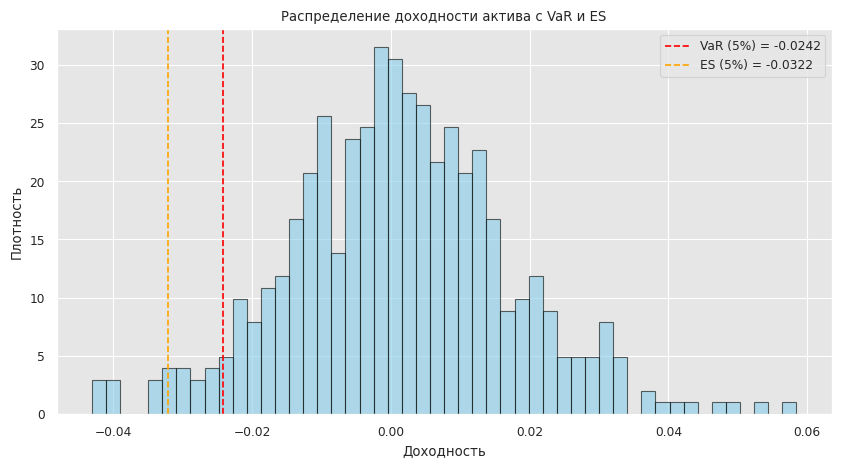

In [29]:
# Данные
returns = arr[:, 0]  # (500,)
alpha = 0.05

# Вычисление VaR и ES 
VaR = -torch.quantile(returns, q=alpha)
losses = returns[returns <= -VaR]
ES = -torch.mean(losses)

# Перевод в NumPy для построения графика
returns_np = returns.numpy()

# Построение графика
plt.figure(figsize=(10, 5))
plt.hist(returns_np, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')
plt.axvline(-VaR.item(), color='red', linestyle='--', label=f'VaR ({alpha*100:.0f}%) = {-VaR.item():.4f}')
plt.axvline(-ES.item(), color='orange', linestyle='--', label=f'ES ({alpha*100:.0f}%) = {-ES.item():.4f}')
plt.title('Распределение доходности актива с VaR и ES')
plt.xlabel('Доходность')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
def predict_multivariate(context, R, alpha):
    # Estimating individual VaR and ES
    n_vars = context.shape[-1]
    VaRs = torch.quantile(context, q=alpha, dim=0) #/ n_vars
    print(VaRs)

    # Индивидуальные ES без деления на n_vars
    ESs = torch.zeros(n_vars)
    for i in range(n_vars):
        context_i = context[:, i]
        VaR_i = VaRs[i]
        # ES_i = context_i[context_i <= VaR_i]
        ES_i = context_i[torch.where(context_i <= VaR_i)[0]]
        # ESs[i] = torch.mean(ES_i)  # уже в минусе, если значения отрицательные
        ESs[i] = torch.sum(ES_i) / (ES_i.shape[0] * n_vars)
        print(VaR_i, ESs[i])

    ESs = ESs.double()
    # Computing final VaR and ES
    # ESs = ESs.float()
    # R = R.float()
    VaRs = VaRs / n_vars
    VaR = -torch.sqrt(VaRs @ R @ VaRs.T)
    ES = -torch.sqrt(ESs @ R @ ESs.T)

    return VaR, ES

In [31]:
VaR_5_TimeGrad, ES_5_TimeGrad = predict_multivariate(arr, pho, 0.01)
VaR_5_TimeGrad, ES_5_TimeGrad 

tensor([-0.0391, -0.0426, -0.0522, -0.0506, -0.0465], dtype=torch.float64)
tensor(-0.0391, dtype=torch.float64) tensor(-0.0083)
tensor(-0.0426, dtype=torch.float64) tensor(-0.0110)
tensor(-0.0522, dtype=torch.float64) tensor(-0.0122)
tensor(-0.0506, dtype=torch.float64) tensor(-0.0110)
tensor(-0.0465, dtype=torch.float64) tensor(-0.0106)


(tensor(-0.0401, dtype=torch.float64), tensor(-0.0461, dtype=torch.float64))

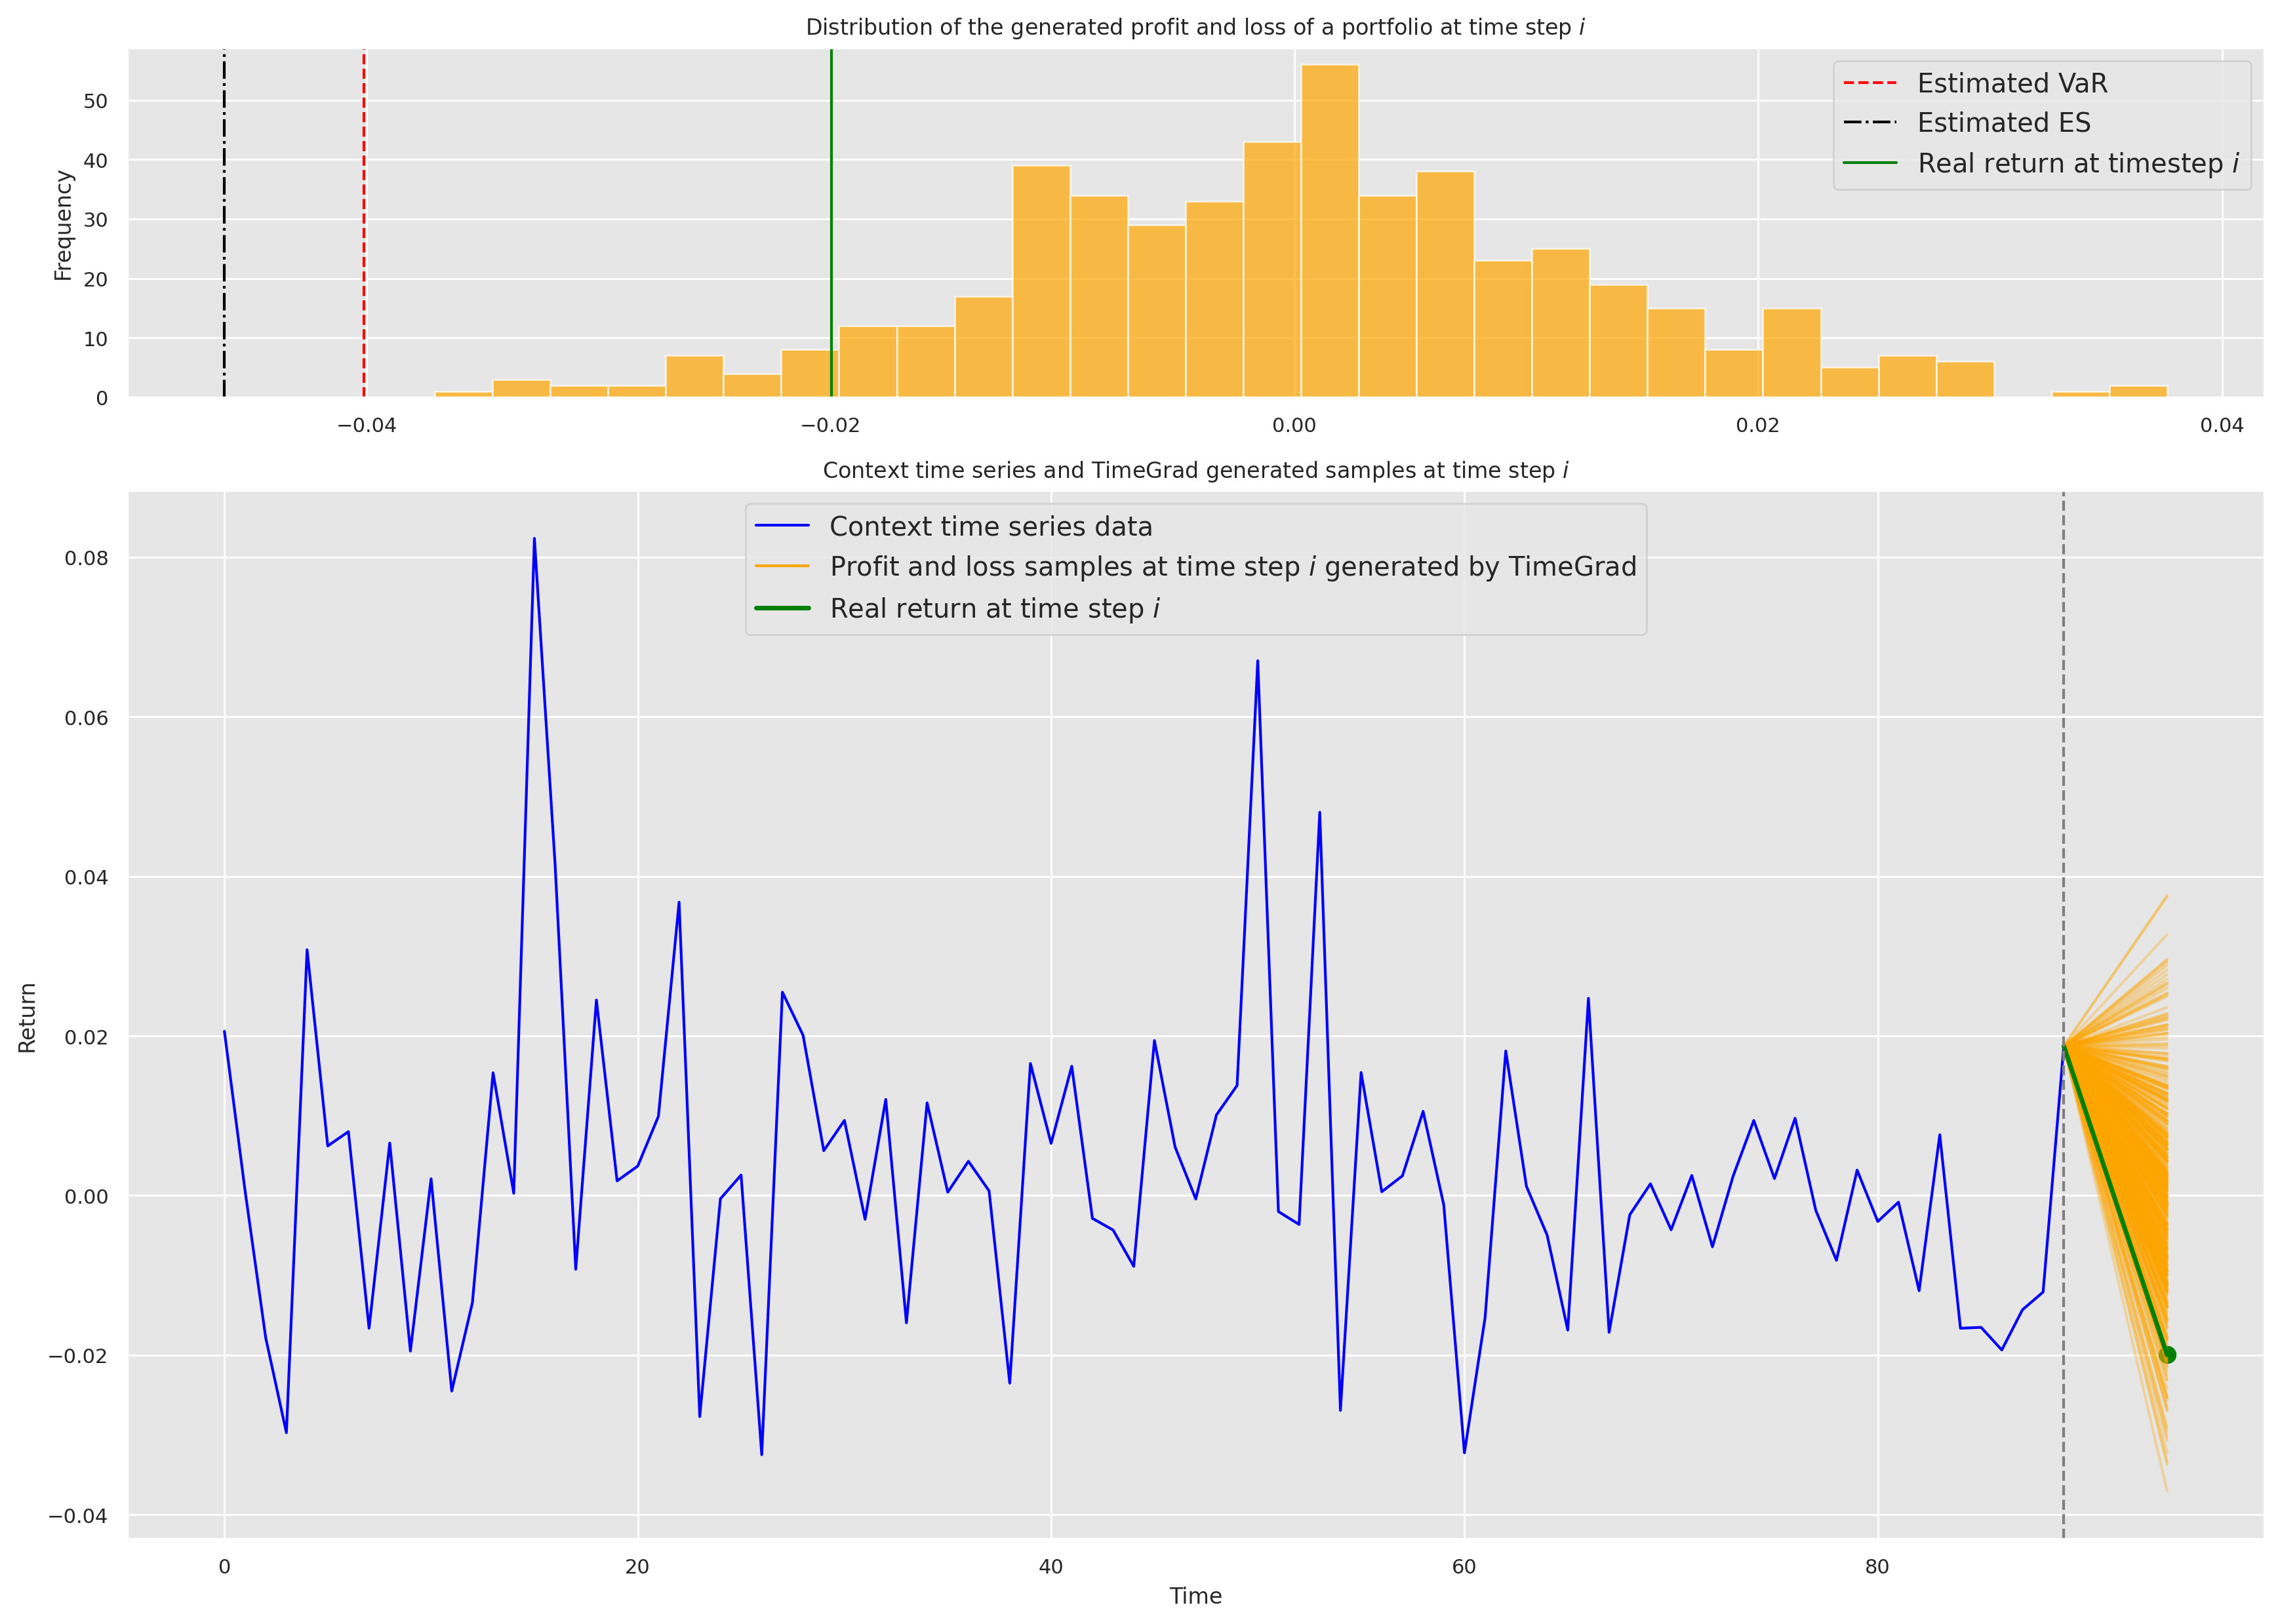

In [32]:
real = test_data_real[j]
test_obs_sques = test_obs.squeeze(0)
arr_np = arr.numpy()  # если arr — это torch.Tensor
portfolio = torch.matmul(arr, weights)
future_steps = 5
time_series = ss.inverse_transform(test_obs_sques)
time_series_portfolio = np.mean(time_series, axis=1)
n_points = time_series_portfolio.shape[0]
n_future_paths = portfolio.shape[0]

# Create a figure with two subplots (one for the histogram and one for the time series)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 3]}, dpi=250)


ax1.hist(portfolio, bins=30, color="orange", alpha=0.7)
ax1.axvline(VaR_5_TimeGrad, linestyle="--", label="Estimated VaR", color="red")
ax1.axvline(ES_5_TimeGrad, linestyle="-.", label="Estimated ES", color="black")
ax1.axvline(real, label="Real return at timestep $i$", color="green")
ax1.set_title('Distribution of the generated profit and loss of a portfolio at time step $i$')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize='large')

# Plot the historical time series on the bottom subplot
ax2.plot(range(n_points), time_series_portfolio, label='Context time series data', color='blue')

# Plot multiple one-step-ahead prediction paths on the bottom subplot
last_time_point = n_points - 1
for i in range(n_future_paths - 1):
    ax2.plot([last_time_point, last_time_point + future_steps], [time_series_portfolio[-1], portfolio[i].item()], color="orange", alpha=0.3)
ax2.plot([last_time_point, last_time_point + future_steps], [time_series_portfolio[-1], portfolio[-1].item()], color="orange", alpha=1, label="Profit and loss samples at time step $i$ generated by TimeGrad")


# Plot real obs
ax2.plot([last_time_point, last_time_point + future_steps], [time_series_portfolio[-1], np.array(real[0][0])], color="green", alpha=1, linewidth=2, label="Real return at time step $i$")
ax2.scatter(last_time_point + future_steps, real, color="green", s=50)

# Mark the last observation in the time series on the bottom subplot
ax2.axvline(x=last_time_point, color='grey', linestyle='--')

ax2.set_xlabel('Time')
ax2.set_ylabel('Return')
ax2.set_title("Context time series and TimeGrad generated samples at time step $i$")
ax2.legend(fontsize='large')
plt.tight_layout()
plt.show()

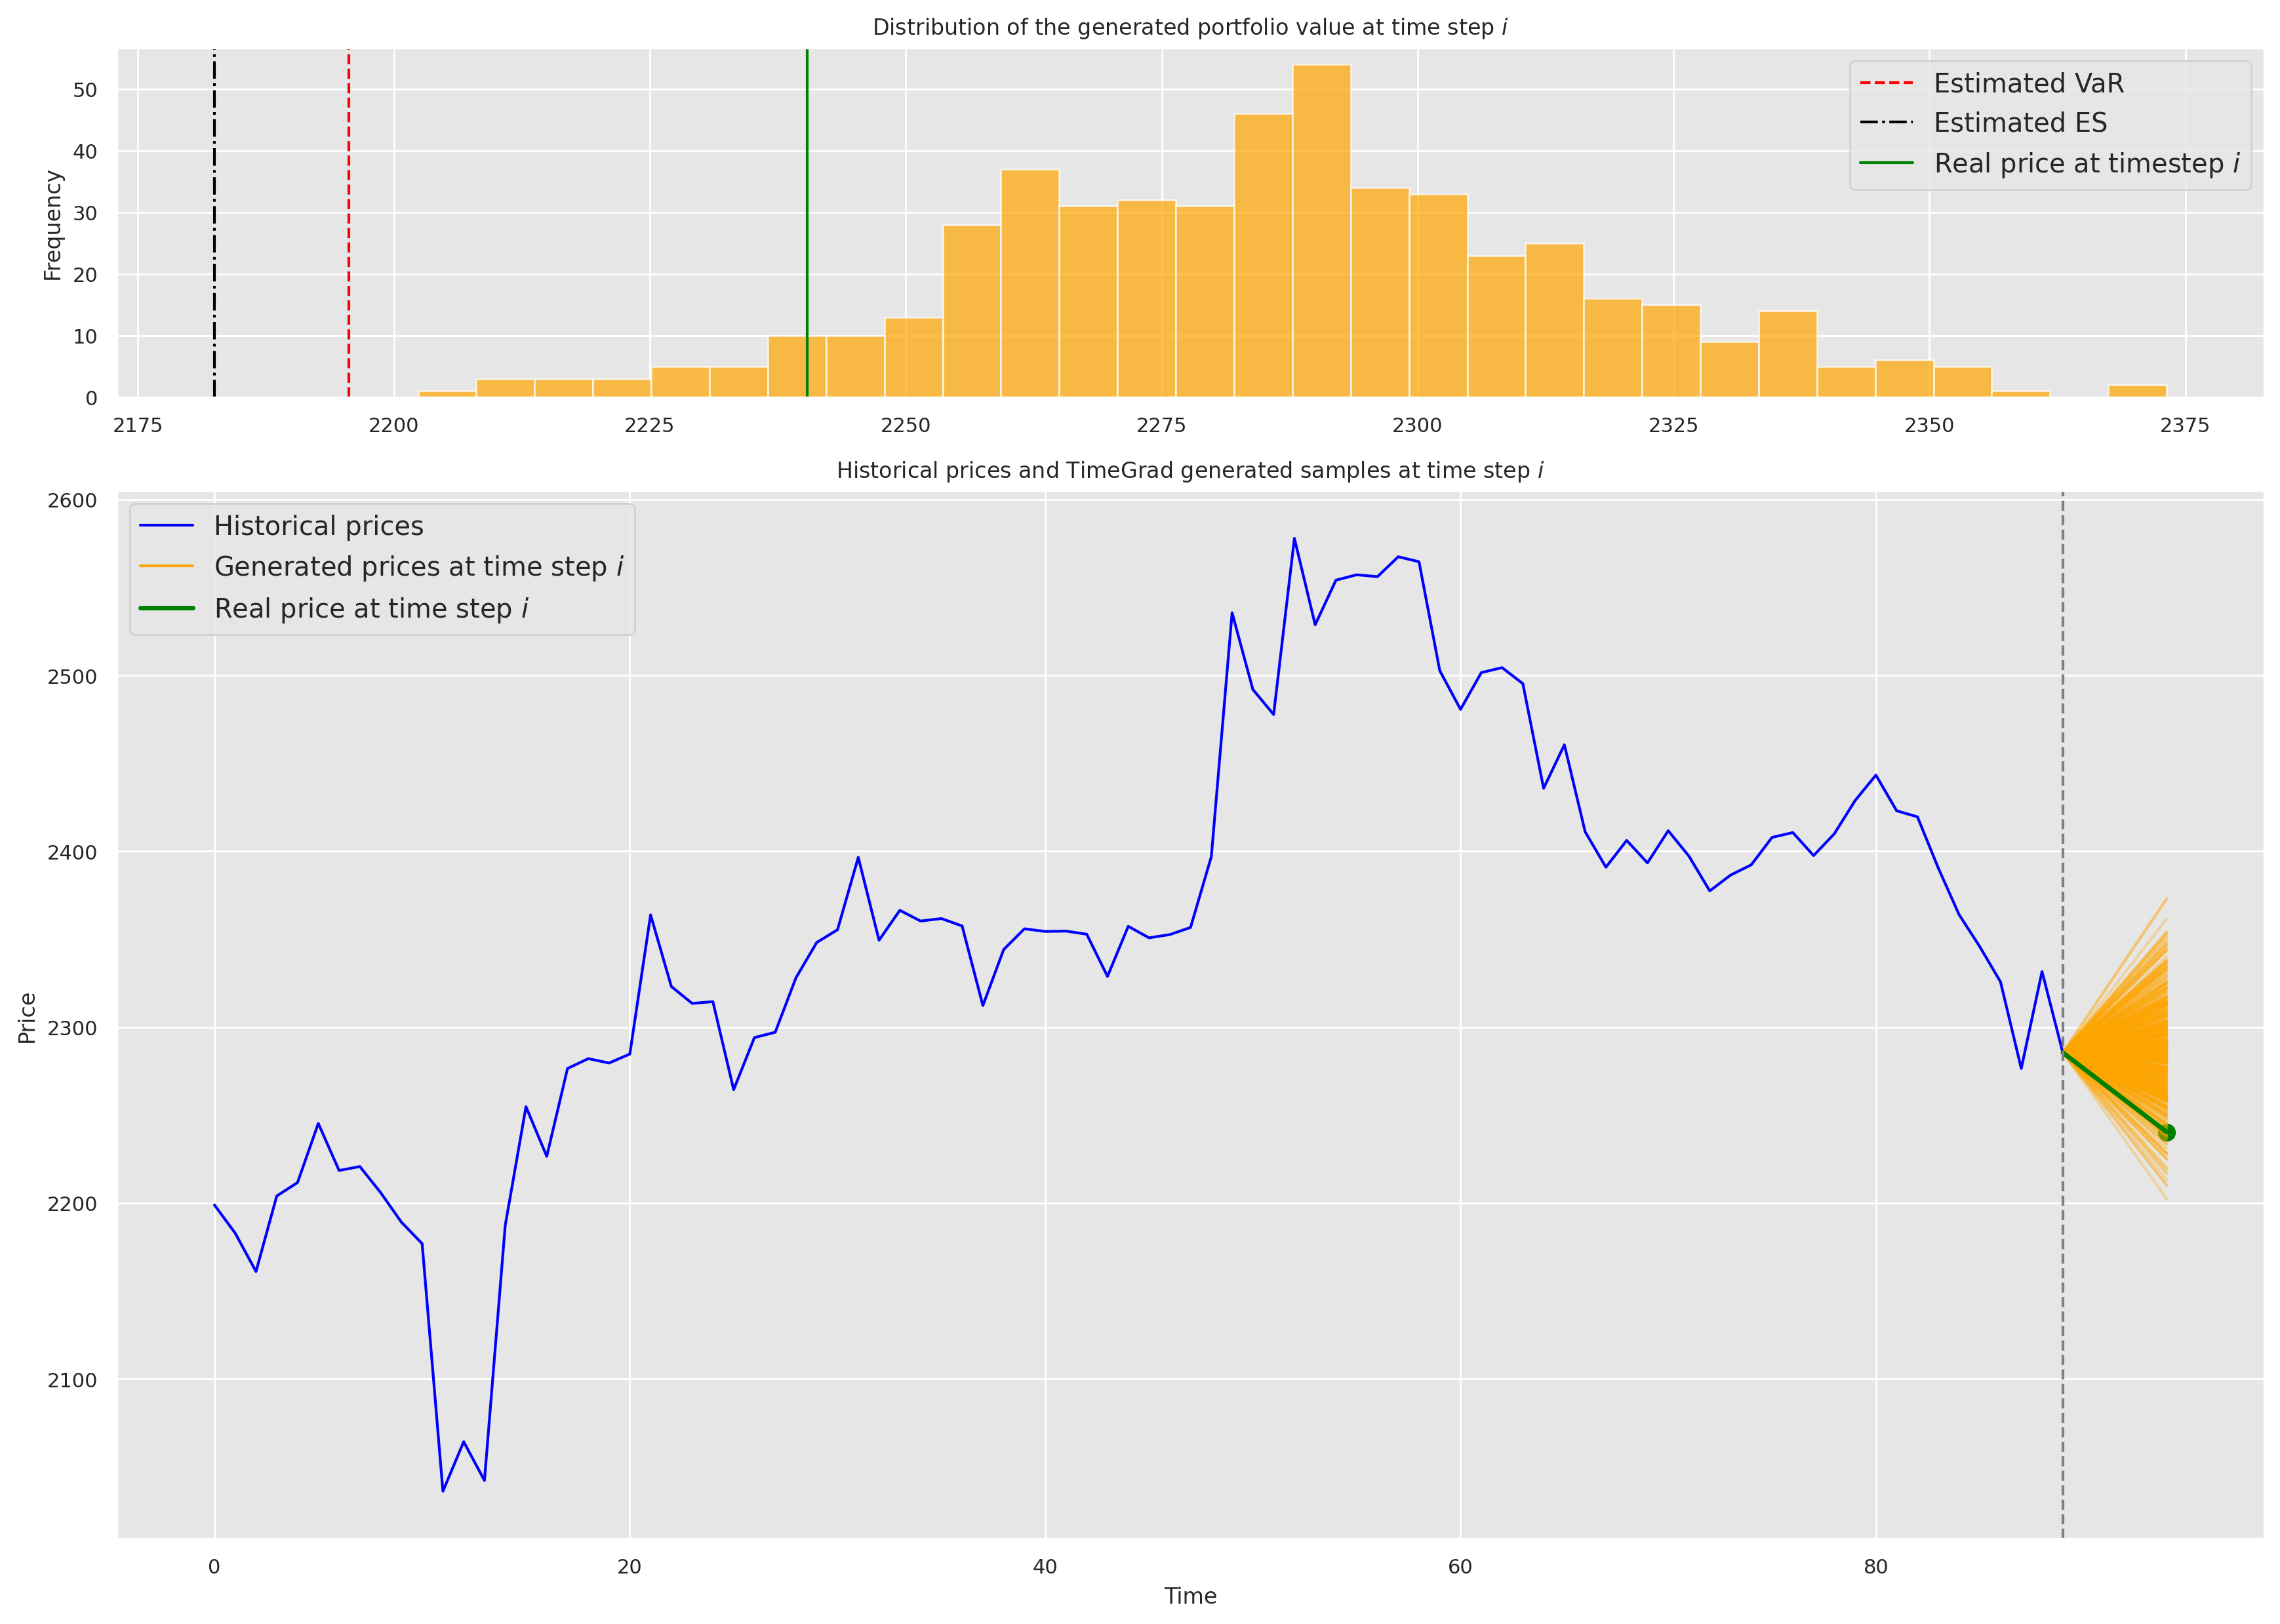

In [33]:

# # Восстанавливаем цены из логарифмических доходностей
def log_returns_to_prices(initial_price, log_returns):
    prices = [initial_price]
    for r in log_returns:
        prices.append(prices[-1] * np.exp(r))
    return np.array(prices)

# # Восстанавливаем train и test цены
initial_price_train = df_my["Index"].iloc[0]  # Начальная цена для train

initial_price_test = df_my[df_my['Date'] <= data_col]["Index"].iloc[-1]

# Восстанавливаем предсказанные доходности в цены
future_predictions_prices = initial_price_test * np.exp(portfolio)
VaR_5_TimeGrad_price = initial_price_test * np.exp(VaR_5_TimeGrad)
ES_5_TimeGrad_price = initial_price_test * np.exp(ES_5_TimeGrad)
real_price = initial_price_test * np.exp(real)

# Модифицируем графики:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 3]}, dpi=250)

# Гистограмма в ценах
ax1.hist(future_predictions_prices, bins=30, color="orange", alpha=0.7)
ax1.axvline(VaR_5_TimeGrad_price, linestyle="--", label="Estimated VaR", color="red")
ax1.axvline(ES_5_TimeGrad_price, linestyle="-.", label="Estimated ES", color="black")
ax1.axvline(real_price, label="Real price at timestep $i$", color="green")
ax1.set_title('Distribution of the generated portfolio value at time step $i$')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize='large')

# Временной ряд в ценах
time_series_prices = df_my[df_my['Date'] <= data_col]["Index"][-90:].values #log_returns_to_prices(initial_price_train, ss.inverse_transform(test_obs.reshape(-1, 1)).flatten())
ax2.plot(range(len(time_series_prices)), time_series_prices, label='Historical prices', color='blue')

# Предсказанные траектории в ценах
last_time_point = len(time_series_prices) - 1
for i in range(n_future_paths - 1):
    ax2.plot(
        [last_time_point, last_time_point + future_steps],
        [time_series_prices[-1], future_predictions_prices[i]],
        color="orange", alpha=0.3
    )
ax2.plot(
    [last_time_point, last_time_point + future_steps],
    [time_series_prices[-1], future_predictions_prices[-1]],
    color="orange", alpha=1, label="Generated prices at time step $i$"
)

# Реальная цена
ax2.plot(
    [last_time_point, last_time_point + future_steps],
    [time_series_prices[-1], np.array(real_price[0][0])],
    color="green", alpha=1, linewidth=2, label="Real price at time step $i$"
)
ax2.scatter(last_time_point + future_steps, real_price, color="green", s=50)

ax2.axvline(x=last_time_point, color='grey', linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.set_title("Historical prices and TimeGrad generated samples at time step $i$")
ax2.legend(fontsize='large')

plt.tight_layout()
plt.show()

# Нужные скрипт

In [9]:
def plot_simulation_results(simulated_prices,
                          real_prices=None,
                          title="Прогноз цены (EGARCH + Монте-Карло)",
                          xlabel="Дни",
                          ylabel="Цена",
                          figsize=(14, 7),
                          show_var_es=True,
                          alpha=0.01,
                          ylim=None):
    """
    Визуализирует результаты симуляции цен с VaR, ES и доверительными интервалами

    Параметры:
    ----------
    simulated_prices : np.ndarray
        Массив симулированных цен (n_simulations × n_days)
    real_prices : pd.Series или np.ndarray, optional
        Фактические значения цен для сравнения
    title : str, optional
        Заголовок графика
    show_ci : bool, optional
        Показывать 95% доверительный интервал
    show_var_es : bool, optional
        Показывать VaR и Expected Shortfall
    ylim : tuple, optional
        Границы оси Y (min, max)
    """
    plt.figure(figsize=figsize)
    n_days = simulated_prices.shape[1]

    # --- Визуализация симуляций ---
    plt.plot(simulated_prices.T, color="blue", alpha=alpha, linewidth=0.5)

    # --- Реальные данные ---
    if real_prices is not None and len(real_prices) == n_days:
        plt.plot(real_prices, color="black", marker="o", label="Реальная цена")

    # # --- Средний прогноз ---
    # mean_prices = simulated_prices.mean(axis=0)
    # plt.plot(mean_prices, color="red", linestyle="--", label="Средний прогноз")

    if show_var_es:
        # --- VaR и ES ---
        for level, var_color, es_color in [(5, "darkred", "darkorange"),
                                         (1, "maroon", "orangered")]:
            var = np.percentile(simulated_prices, level, axis=0)
            es = np.array([
                simulated_prices[simulated_prices[:, day] <= var[day], day].mean()
                for day in range(n_days)
            ])
            plt.plot(var, color=var_color, linestyle=":", label=f"VaR {level}%")
            plt.plot(es, color=es_color, linestyle="-.", label=f"ES {level}% (CVaR)")

    # --- Настройки графика ---
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid()

    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

# Моделируем базовый вариант

In [10]:
n_samples = 5000 #5000
horizon = 10
n_assets = test_data_context.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context[[0]] for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths = future_paths.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [11]:
future_paths.shape

(10, 5000, 5)

In [12]:
for day in range(horizon):
    future_paths[day, :, :] = ss.inverse_transform(
         future_paths[day, :, :]
    )

In [13]:
np.save("future_mult_basic.npy", future_paths)

# 1 стресс-тест Падение каждой акции на 5%

In [14]:
return_cols = ['LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK']
df_my_last_train = df_my[df_my['Date'] <= data_col][return_cols][-91:]

In [15]:
stress_down = 0.9
# Создаём копию, чтобы не изменять оригинал
test_stress_data = df_my_last_train.copy()

# Уменьшаем последнее значение на 10% относительно предыдущего (второго с конца)
test_stress_data.iloc[-1] = test_stress_data.iloc[-2] * stress_down
test_stress_data_log = np.log(test_stress_data / test_stress_data.shift(1)).dropna()
# Преобразование и перевод в тензор
test_data_context_stress = torch.tensor(
    ss.transform(test_stress_data_log),
    dtype=torch.float32
).unsqueeze(0)

In [16]:
n_samples = 5000
horizon = 10
n_assets = test_data_context_stress.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context_stress[[0]] for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths_stress_1 = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths_stress_1[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths_stress_1 = future_paths_stress_1.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [17]:
for day in range(horizon):
    future_paths_stress_1[day, :, :] = ss.inverse_transform(
         future_paths_stress_1[day, :, :]
    )

In [18]:
print(future_paths_stress_1.shape)
np.save("stress_1_mult.npy", future_paths_stress_1)

(10, 5000, 5)


# 2 стресс-тест

In [21]:
def apply_volatility_stress(prices, n_days_stress=5, stress_factor=1.2):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    log_returns_stressed = log_returns.copy()
    plt.plot(log_returns_stressed)
    log_returns_stressed[-n_days_stress:] *= stress_factor
    plt.plot(log_returns_stressed)

    test_data_context_stress = torch.tensor(
    ss.transform(log_returns_stressed),
    dtype=torch.float32
    ).unsqueeze(0)

    return log_returns_stressed, test_data_context_stress

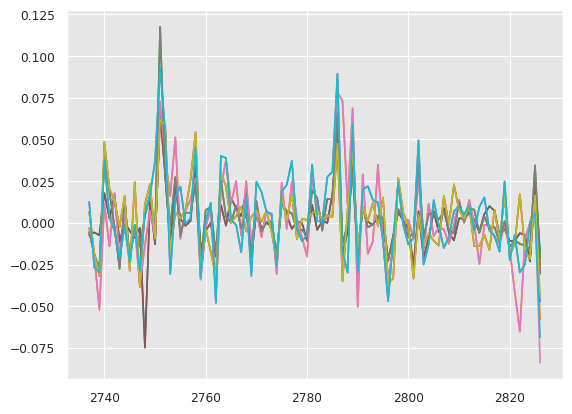

In [22]:
log_returns_stressed, test_data_context_volat = apply_volatility_stress(df_my_last_train, n_days_stress=1, stress_factor=1.45)

In [23]:
n_samples = 5000
horizon = 10
n_assets = test_data_context_stress.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context_volat[[0]] for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths_stress_2 = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths_stress_2[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths_stress_2 = future_paths_stress_2.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [24]:
for day in range(horizon):
    future_paths_stress_2[day, :, :] = ss.inverse_transform(
         future_paths_stress_2[day, :, :]
    )

In [25]:
print(future_paths_stress_2.shape)
np.save("stress_2_mult.npy", future_paths_stress_2)

(10, 5000, 5)


# 3 стресс-сценарий

In [26]:
# Загрузка данных из .npy файла
synthetic_prices_basic  = np.load('future_mult_basic.npy')

# Проверка данных
print("Тип данных:", type(synthetic_prices_basic))  # <class 'numpy.ndarray'>
print("Форма массива:", synthetic_prices_basic.shape)  # (размерность, например, (forecast_horizon, n_simulations))

transposed_prices_basic = synthetic_prices_basic.T
print("Форма массива:", transposed_prices_basic.shape)  # (размерность, например, (n_simulations, forecast_horizon))

Тип данных: <class 'numpy.ndarray'>
Форма массива: (10, 5000, 5)
Форма массива: (5, 5000, 10)


In [28]:
transposed_prices_basic[0].shape

(5000, 10)

In [29]:
from scipy.stats import t
# Собери вектор из них для 1-го шага прогноза:
mu = np.array([transposed_prices_basic[ticker][:, 0].mean() for ticker in range(5)])
R = np.column_stack([transposed_prices_basic[ticker][:, 0] for ticker in range(5)])
Sigma = np.cov(R.T)

weights = np.array([0.2899, 0.2696, 0.2432, 0.1104, 0.00869], dtype=np.float32)  # Явно указываем float32
w = weights / weights.sum()

df_t = 3  # Степени свободы (меньше = тяжелее хвосты)
p = 0.99
k_t = t.ppf(p, df_t)

Sigma_w = Sigma @ w
denominator = np.sqrt(w.T @ Sigma_w)
r_star = mu - k_t * Sigma_w / denominator
worst_loss = -w.T @ r_star

In [31]:
r_star

array([-0.05670656, -0.05995746, -0.05874441, -0.05853102, -0.03896552])

In [33]:
stress_down = 1 + r_star
# Создаём копию, чтобы не изменять оригинал
test_stress_data = df_my_last_train.copy()

# Уменьшаем последнее значение на 10% относительно предыдущего (второго с конца)
test_stress_data.iloc[-1] = test_stress_data.iloc[-2] * stress_down
test_stress_data_log = np.log(test_stress_data / test_stress_data.shift(1)).dropna()
# Преобразование и перевод в тензор
test_data_context_stress = torch.tensor(
    ss.transform(test_stress_data_log),
    dtype=torch.float32
).unsqueeze(0)

In [34]:
n_samples = 5000
horizon = 10
n_assets = test_data_context_stress.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context_stress[[0]] for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths_stress_3 = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths_stress_3[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths_stress_3 = future_paths_stress_3.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [ ]:
for day in range(horizon):
    future_paths_stress_3[day, :, :] = ss.inverse_transform(
         future_paths_stress_3[day, :, :]
    )

In [ ]:
print(future_paths_stress_3.shape)
np.save("stress_3_mult.npy", future_paths_stress_3)